In [14]:
import os
import pandas as pd
def list_files(folder_path):
    from tqdm import tqdm
    all_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # print(os.path.join(root, file))
            fpath = os.path.join(root, file)
            if fpath.endswith(".json"):
                all_files.append(os.path.join(root, file))
    return all_files
all_files = list_files("PATH_TO_REWARDBENCH_RESULT/eval-set-scores")

def load_results(method, work_dir):
    eval_files = os.listdir(work_dir)
    eval_files = [f for f in eval_files if f.startswith(f"{method}_eval") and "eval" in f and "data" not in f]
    eval_dfs = []
    for f in eval_files:
        df = pd.read_csv(os.path.join(work_dir, f))
        df["model"] = [f.replace(f"{method}_", "").replace(".csv", "").replace(f"eval_", "") for _ in range(len(df))]
        df = df.drop(columns=["Unnamed: 0"])
        eval_dfs.append(df)
    # sort the df with the rank
    eval_df = pd.concat(eval_dfs)
    df = eval_df
    df[f"score_{method}"] = (df["Chat"] + df["Chat Hard"] + df["Reasoning"] + df["Safety"]) / 4 * 100
    df.sort_values(by=f"score_{method}", ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

def check_model_type(model_name):
    model_file = [fpath for fpath in all_files if model_name in fpath]
    model_file = model_file[0]
    df = pd.read_json(model_file)
    return df["model_type"].values[0]

33
Index(['model', 'Original Reward', 'RC-LWR'], dtype='object')
Do not have the penalty method
[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), (0.8352941176470589, 0.3686274509803922, 0.0), (0.8, 0.47058823529411764, 0.7372549019607844)]


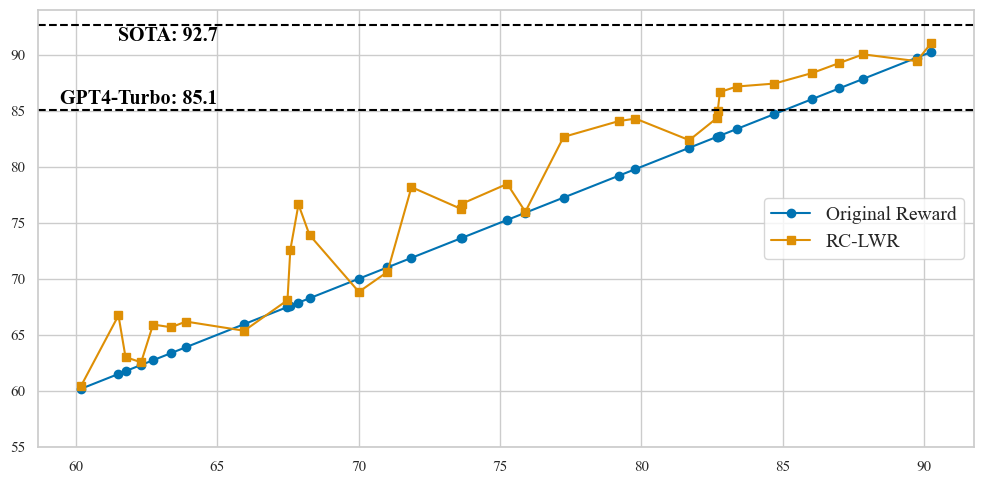

/var/folders/2h/1h16rrxx1mvcbyd70jx8_vx40000gn/T/ipykernel_55439/3270435820.py:146: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  ax2 = sns.stripplot(data=data, x='Category', y='Value', hue='Category', alpha=1.0, legend=False,
/var/folders/2h/1h16rrxx1mvcbyd70jx8_vx40000gn/T/ipykernel_55439/3270435820.py:195: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), fontdict={"size": 14})


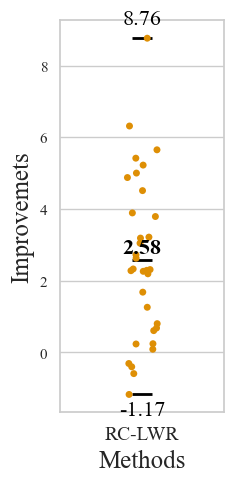

In [15]:
# Plotting the line chart with scaltter plots for in different subplots
MODEL_TYPE = "BT"  # choose from DPO or BT
methods = [
    "original",
    "penalty", 
    "mean_reward",
    "LWR", 
    "LWR_penalty",
]
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

work_dir = "PATH_TO_YOUR_OUTPUT_DIR"
res  = None
min_score = 999
for method in methods:
    if "md" in work_dir and "penalty" in method:
        continue
    method_df = load_results(method, work_dir=work_dir)
    method_df.drop(columns=["Chat", "Chat Hard", "Reasoning", "Safety", "preference_changed"], inplace=True)
    if min(method_df[f"score_{method}"]) < min_score:
        min_score = min(method_df[f"score_{method}"])
    if res is None:
        res = method_df
    else:
        res = pd.merge(res, method_df, on="model", how="outer")
# set the column ``model`` as the index
res.set_index("model", inplace=True)
res.reset_index(inplace=True)
res.sort_values(by="score_original", ascending=False, inplace=True)
res.reset_index(drop=True, inplace=True)
# add the model type
res["model_type"] = [check_model_type(model_name) for model_name in res["model"]]
# rename the columns
rename_dict = {
    "score_original": "Original Reward", 
    "score_penalty": "Length Penalty", 
    "score_mean_reward": "RC-Mean", 
    "score_LWR": "RC-LWR", 
    "score_LWR_penalty": "RC-LWR-Penalty"
}
res.to_csv(f"{work_dir.split('/')[-1]}.csv")
res.drop(columns=[c for c in res.columns if c.startswith("spearman")], inplace=True)
res.rename(columns=rename_dict, inplace=True)
seq_res = res[res["model_type"] == "Seq. Classifier"]
dpo_res = res[res["model_type"] == "DPO"]


if MODEL_TYPE == "BT":
    df = seq_res.drop(columns=["model_type"])
else:
    df = dpo_res.drop(columns=["model_type"])
df = df.sort_values(by="Original Reward", ascending=True)
if MODEL_TYPE == "BT":
    df = df[df["Original Reward"] > 50]
print(len(df))
min_score = 55
# Calculate Deltas
print(df.columns)
if "RC-Mean" in df.columns:
    df["RC-Mean Delta"] = df["RC-Mean"] - df["Original Reward"]
df["RC-LWR Dealta"] = df["RC-LWR"] - df["Original Reward"]
try:
    df["RC-LWR-Penalty Delta"] = df["RC-LWR-Penalty"] - df["Original Reward"]
    df["Length Penalty Delta"] = df["Length Penalty"] - df["Original Reward"]
except:
    print("Do not have the penalty method")
    pass

sns.set(style="whitegrid", font="Times New Roman")
fig1, ax1 = plt.subplots(figsize=(10, 5))
colors = sns.color_palette("colorblind", 5)
print(colors)
markers = ['o', 's', 'D', '^', '*']
orders = [1, 2, 3, 4, 5]
# Plot the line chart for the reward metrics
for column in df.columns[1:6 if "len" in work_dir else 4]:
    if column in rename_dict.values():
        ax1.plot(
            df["Original Reward"], df[column], 
            marker=markers.pop(0), label=column, 
            color=colors.pop(0),
            zorder=orders.pop(0),
            # alpha=0.7,
        )

if MODEL_TYPE == "BT":
    ax1.set_ylim(min_score, 94)
else:
    ax1.set_ylim(45, 85)
if MODEL_TYPE == "BT":
    gpt4_turbo_score = 85.1
    ax1.axhline(y=gpt4_turbo_score, color='black', linestyle='--')
    plt.text(65, gpt4_turbo_score+0.5, 'GPT4-Turbo: 85.1', horizontalalignment='right', size='large', color='black', weight='semibold')

    sota_score = 92.7
    ax1.axhline(y=sota_score, color='black', linestyle='--')
    plt.text(65, sota_score-1.5, 'SOTA: 92.7', horizontalalignment='right', size='large', color='black', weight='semibold')
# Add legends
if MODEL_TYPE == "BT":
    ax1.legend(loc="center right", fontsize=14)
else:
    ax1.legend(loc="upper left", fontsize=14)
models_indices = range(len(df["model"]))
if "md" in work_dir:
    if "output_len_char" in work_dir:
        data = pd.DataFrame({
            "Model": df["model"].tolist() ,
            "Value": df["RC-LWR Dealta"].tolist(),
            "Category": ["RC-LWR"] * len(df),
        })
    else:
        data = pd.DataFrame({
            "Model": df["model"].tolist() * 2,
            "Value": df["RC-Mean Delta"].tolist() + df["RC-LWR Dealta"].tolist(),
            "Category": ["RC-Mean"] * len(df) + ["RC-LWR"] * len(df),
        })
else:
    data = pd.DataFrame({
        "Model": df["model"].tolist() * 4,
        "Value": df["Length Penalty Delta"].tolist() + df["RC-Mean Delta"].tolist() + df["RC-LWR Dealta"].tolist() + df["RC-LWR-Penalty Delta"].tolist(),
        "Category": ["Length Penalty"] * len(df) + ["RC-Mean"] * len(df) + ["RC-LWR"] * len(df) + ["RC-LWR-Penalty"] * len(df),
    })
    
plt.tight_layout()
plt.show()

fig2, ax2 = plt.subplots(figsize=(2.5, 5))
unique_models = data['Model'].unique()

ax2 = sns.stripplot(data=data, x='Category', y='Value', hue='Category', alpha=1.0, legend=False, 
                    palette=sns.color_palette("colorblind", 5)[1:], 
                    jitter=True)
# add annotation
mean_values = data.groupby('Category')['Value'].mean()
max_values = data.groupby('Category')['Value'].max()
min_values = data.groupby('Category')['Value'].min()
median_values = data.groupby('Category')['Value'].median()

if "md" in work_dir:
    if "output_len_char" in work_dir:
        methods = ["RC-LWR"]
    else:
        methods = ["RC-Mean","RC-LWR"]
else:
    methods = [
        #"Original Reward",
        "Length Penalty", 
        "RC-Mean",
        "RC-LWR", 
        "RC-LWR-Penalty",
    ]
category_order = {name: order for order, name in enumerate(methods)}

for cat, mean in mean_values.items():
    idx = category_order[cat]
    ax2.annotate(f'{mean:.2f}', xy=(idx, mean), xytext=(0, 5), textcoords='offset points', ha='center', color='black', fontsize=16, fontweight='bold')

for cat, max_val in max_values.items():
    idx = category_order[cat]
    ax2.annotate(f'{max_val:.2f}', xy=(idx, max_val), xytext=(0, 10), textcoords='offset points', ha='center', color='black', fontsize=16)

for cat, min_val in min_values.items():
    idx = category_order[cat]
    ax2.annotate(f'{min_val:.2f}', xy=(idx, min_val), xytext=(0, -15), textcoords='offset points', ha='center', color='black', fontsize=16)

import numpy as np
mean_plot = sns.pointplot(x='Category', y='Value', data=data, estimator=np.mean, color='black', linestyles='', markers='_', errorbar=None, markersize=15)
max_plot = sns.pointplot(x='Category', y='Value', data=data, estimator=np.max, color='black', linestyles='', markers='_', errorbar=None, markersize=15)
min_plot = sns.pointplot(x='Category', y='Value', data=data, estimator=np.min, color='black', linestyles='', markers='_', errorbar=None, markersize=15)
ax2.set_ylabel("Improvemets", fontdict={"size": 18})
ax2.set_xlabel("Methods", fontdict={"size": 18})
ax2.set_xticklabels(ax2.get_xticklabels(), fontdict={"size": 14})
plt.tight_layout()
plt.show()
